In [1]:
import os
import gc
import sys
import keras
import torch
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sys.path.append(str(Path().resolve().parent))

from src.arch import DeepEntropy, masked_mse_loss
# from src.data_loader import load_NMR_dataset

In [2]:
# loading embedding

nmr_data = torch.load(Path().resolve().parent / "data/embeddings/nmr_merged.pt")

nmr_embeddings = []
nmr_plddt = []
nmr_gscores = []
nmr_gscores_masks = []


for nmr_ele in nmr_data:
    emb = nmr_ele["embedding"].numpy()  # shape: (L, 1024)
    plddt = np.array(nmr_ele["plddt"], dtype=np.float32)  # shape: (L,)
    
    raw_gscores = nmr_ele["gscores"]
    mask = np.array([v is not None for v in raw_gscores], dtype=bool)
    cleaned_gscores = np.array([0.0 if v is None else v for v in raw_gscores], dtype=np.float32)

    if emb.shape[0] != plddt.shape[0] or emb.shape[0] != len(cleaned_gscores):
        print("Unmatching dimension!")
        continue

    nmr_embeddings.append(emb)
    nmr_plddt.append(plddt)
    nmr_gscores.append(cleaned_gscores)
    nmr_gscores_masks.append(mask)


In [3]:
print(len(nmr_embeddings))

994


In [4]:
disprot_data = torch.load(Path().resolve().parent / "data/embeddings/disprot_merged.pt")

disprot_embeddings = []
disprot_plddt = []
disprot_disorder_values = []

for idx, disprot_ele in enumerate(disprot_data):
    try:
        emb = disprot_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(disprot_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder_value = np.array([disprot_ele["disorder_content"]], dtype=np.float32)  # scalar

        # Shape checks
        if emb.shape[0] != plddt.shape[0]:
            print(f"[{idx}] Shape mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}")
            continue
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dim: got {emb.shape[1]}, expected 1024")
            continue

        disprot_embeddings.append(emb)
        disprot_plddt.append(plddt)
        disprot_disorder_values.append(disorder_value)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

In [5]:
print(len(disprot_embeddings))

1620


In [6]:
softDis_data = torch.load(Path().resolve().parent / "data/embeddings/softdis_merged.pt")

softDis_embeddings = []
softDis_plddt = []
softDis_disorder_values = []

for idx, softDis_ele in enumerate(softDis_data):
    try:
        emb = softDis_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(softDis_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder = np.array(softDis_ele["soft_disorder_frequency"], dtype=np.float32)  # shape: (L,)

        # Shape checks
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dimension: got {emb.shape[1]}, expected 1024")
            continue
        if emb.shape[0] != plddt.shape[0] or emb.shape[0] != disorder.shape[0]:
            print(f"[{idx}] Length mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}, disorder L={disorder.shape[0]}")
            continue

        softDis_embeddings.append(emb)
        softDis_plddt.append(plddt)
        softDis_disorder_values.append(disorder)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

[1714] Length mismatch: embedding L=1038, plddt L=1033, disorder L=1038
[2755] Length mismatch: embedding L=549, plddt L=571, disorder L=549
[2981] Length mismatch: embedding L=644, plddt L=645, disorder L=644
[3650] Length mismatch: embedding L=488, plddt L=221, disorder L=488


In [7]:
print(len(softDis_embeddings))

4068


In [8]:
# temporarily reducing sample size that the CPU can handle, later with larger compute instance run on all data

# nmr_embeddings = nmr_embeddings[:10]
# nmr_plddt = nmr_plddt[:10]
# nmr_gscores = nmr_gscores[:10]

# disprot_embeddings = disprot_embeddings[:10]
# disprot_plddt = disprot_plddt[:10]
# disprot_disorder_values = disprot_disorder_values[:10]

# softDis_embeddings = softDis_embeddings[:10]
# softDis_plddt = softDis_plddt[:10]
# softDis_disorder_values = softDis_disorder_values[:10]

In [9]:

disprot_masks = [np.ones_like(plddt, dtype=bool) for plddt in disprot_plddt]
softDis_masks = [np.ones_like(plddt, dtype=bool) for plddt in softDis_plddt]
combined_data = []

for idx in range(len(nmr_embeddings)):
    combined_data.append((
        nmr_embeddings[idx],
        nmr_plddt[idx],
        nmr_gscores[idx],
        nmr_gscores_masks[idx],
        "g_scores"
    ))

for idx in range(len(disprot_embeddings)):
    combined_data.append((
        disprot_embeddings[idx],
        disprot_plddt[idx],
        disprot_disorder_values[idx],
        disprot_masks[idx],
        "disprot_disorder"
    ))

for idx in range(len(softDis_embeddings)):
    combined_data.append((
        softDis_embeddings[idx],
        softDis_plddt[idx],
        softDis_disorder_values[idx],
        softDis_masks[idx],
        "softdis_disorder"
    ))


### Train-Validation-Test split

In [10]:
random.seed(42)
random.shuffle(combined_data)

total = len(combined_data)
train_end = int(0.7 * total)
val_end = int(0.9 * total)

train_data = combined_data[:train_end]
val_data = combined_data[train_end:val_end]
test_data = combined_data[val_end:]

In [11]:
entropy = DeepEntropy()
print(entropy.encoder.summary())
print(entropy.nmr_head_model.summary())
print(entropy.DisProt_head_model.summary())
print(entropy.softdis_head_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings          │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, None, 64)  │    196,672 │ embeddings[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, None, 64)  │        256 │ plddt[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ conv1d_12[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ conv1d_13[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, None, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, None, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, None, 64)  │          0 │ activation_18[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, None, 64)  │          0 │ activation_19[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 128) │          0 │ dropout_18[0][0], │
│ (Concatenate)       │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, None, 32)  │     12,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, None, 32)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, None, 32)  │          0 │ activation_20[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, None, 32)  │      3,104 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ conv1d_15[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, None, 32)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 212,736 (831.00 KB)

 Trainable params: 212,736 (831.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, None, 16)       │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, None, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_scores (Dense)                │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,889 (15.19 KB)

 Trainable params: 3,889 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, None, 16)       │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, None, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disorder_content (Dense)        │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,889 (15.19 KB)

 Trainable params: 3,889 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, None, 16)       │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_17          │ (None, None, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ soft_disorder_frequency (Dense) │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,889 (15.19 KB)

 Trainable params: 3,889 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.0012

In [13]:

# Compile the model
entropy.compile(
    NMR_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    DisProt_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    SoftDis_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    NMR_head_loss_fn = masked_mse_loss,
    # DisProt_head_loss_fn = keras.losses.MeanSquaredError(),
    DisProt_head_loss_fn = keras.losses.MeanAbsoluteError(),
    SoftDis_head_loss_fn = keras.losses.MeanSquaredError()
)

In [14]:
input_embeddings, input_plddt, _, _, _ = train_data[0]
entropy.build_init(
    embedding_shape = (1, input_embeddings.shape[0], input_embeddings.shape[1]), 
    plddt_shape = (1, input_plddt.shape[0])
)

All the heads and optimizers are initialized. Good luck with the training loop!


In [15]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_mask_new_loss_&_bn_dropout_all")
dir_path = f"{str(Path().resolve().parent)}/data/models/{timestamp}"
os.makedirs(dir_path, exist_ok=True)

with open(os.path.join(dir_path, "model_config.json"), 'w') as f:
    f.write(entropy.to_json())

In [16]:

nmr_loss_per_epoc = []
disprot_loss_per_epoc = []
softdis_loss_per_epoc = []

nmr_loss_per_sample_total = []
disprot_loss_per_sample_total = []
softdis_loss_per_sample_total = []

val_nmr_losses_per_epoc = []
val_disprot_losses_per_epoc = []
val_softdis_losses_per_epoc = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}")
    random.shuffle(train_data)

    nmr_loss, disprot_loss, softdis_loss = [], [], []

    for input_embeddings, input_plddt, target, mask, task_flag in train_data:
        entropy.target_flag_ = task_flag

        # Convert to tensors and expand dims
        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
        target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)
        mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

        # Call model
        data = (input_embeddings_tf, input_plddt_tf, target_tf, mask_tf)
        history = entropy.fit(data)
        loss = history.history['loss'][0]
        print(f"{task_flag} head : epoch {epoch + 1}")

        # data = (input_embeddings_tf, input_plddt_tf, target_tf, mask_tf)
        # loss = entropy.train_on_batch(data)
        # print(f"{task_flag} head : epoch {epoch + 1} : loss {loss}")

        # Save loss per task
        if task_flag == "g_scores":
            nmr_loss.append(loss)
        elif task_flag == "disprot_disorder":
            disprot_loss.append(loss)
        else:
            softdis_loss.append(loss)

    # Save average losses per epoch
    nmr_loss_per_epoc.append(sum(nmr_loss) / len(nmr_loss) if nmr_loss else None)
    disprot_loss_per_epoc.append(sum(disprot_loss) / len(disprot_loss) if disprot_loss else None)
    softdis_loss_per_epoc.append(sum(softdis_loss) / len(softdis_loss) if softdis_loss else None)

    nmr_loss_per_sample_total.extend(nmr_loss)
    disprot_loss_per_sample_total.extend(disprot_loss)
    softdis_loss_per_sample_total.extend(softdis_loss)

    # Validation
    val_nmr_losses = []
    val_disprot_losses = []
    val_softdis_losses = []

    for input_embeddings, input_plddt, target, mask, task_flag in val_data:
        entropy.target_flag_ = task_flag

        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
        target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)
        mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

        data = (input_embeddings_tf, input_plddt_tf)
        prediction = entropy.predict(data)

        if task_flag == "g_scores":
            loss = entropy.NMR_head_loss_fn(target_tf, prediction, mask_tf)
            val_nmr_losses.append(loss)

        elif task_flag == "disprot_disorder":
            loss = entropy.DisProt_head_loss_fn(target_tf, prediction)
            val_disprot_losses.append(loss)

        else:
            loss = entropy.SoftDis_head_loss_fn(target_tf, prediction)
            val_softdis_losses.append(loss)

    val_nmr_losses_per_epoc.append(sum(val_nmr_losses) / len(val_nmr_losses) if val_nmr_losses else 0)
    val_disprot_losses_per_epoc.append(sum(val_disprot_losses) / len(val_disprot_losses) if val_disprot_losses else 0)
    val_softdis_losses_per_epoc.append(sum(val_softdis_losses) / len(val_softdis_losses) if val_softdis_losses else 0)


    entropy.encoder.save_weights(os.path.join(dir_path, "encoder.weights.h5"))
    entropy.nmr_head_model.save_weights(os.path.join(dir_path, "nmr_head.weights.h5"))
    entropy.DisProt_head_model.save_weights(os.path.join(dir_path, "disProt_head.weights.h5"))
    entropy.softdis_head_model.save_weights(os.path.join(dir_path, "softDis_head.weights.h5"))

    # clearing memory
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()



Epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4743
softdis_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3739
disprot_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1920
g_scores head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2993
softdis_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2608
softdis_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2150
softdis_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2915
disprot_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0763
disprot_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1050
g_scores head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0041
disprot_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2218
softdis_disorder head : epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2425
softdis_disorder head :

KeyboardInterrupt: 

In [17]:
print(nmr_loss_per_epoc)
print(disprot_loss_per_epoc)
print(softdis_loss_per_epoc)

print(val_nmr_losses_per_epoc)
print(val_disprot_losses_per_epoc)
print(val_softdis_losses_per_epoc)

[0.1104122920840569, 0.10638064685966361, 0.10530251227507931, 0.1073128299561212, 0.10531124336558749, 0.11182735113739731, 0.10178495283668534, 0.10225201195291905, 0.10235013337617177, 0.1036416574309859]
[0.168591461331311, 0.13779880842284542, 0.13917423127042863, 0.1365469785013576, 0.13478851452622986, 0.14578221461494395, 0.12622922845720047, 0.12649067945755313, 0.12103309346590221, 0.12252144611528708]
[0.22113285790313356, 0.21602700657672827, 0.21563034436931333, 0.215727180042247, 0.21373328345969658, 0.2135928932075012, 0.2141188751671287, 0.21422193087213354, 0.21420006841199307, 0.21335449134849416]
[<tf.Tensor: shape=(), dtype=float32, numpy=20.356456756591797>, <tf.Tensor: shape=(), dtype=float32, numpy=14.636140823364258>, <tf.Tensor: shape=(), dtype=float32, numpy=15.137971878051758>, <tf.Tensor: shape=(), dtype=float32, numpy=14.896756172180176>, <tf.Tensor: shape=(), dtype=float32, numpy=18.315134048461914>, <tf.Tensor: shape=(), dtype=float32, numpy=18.5057468414

In [18]:
print(entropy.NMR_head_loss)
print(entropy.DisProt_head_loss)
print(entropy.SoftDis_head_loss)

[]
[<tf.Tensor 'div_no_nan:0' shape=() dtype=float32>]
[<tf.Tensor 'div_no_nan:0' shape=() dtype=float32>]


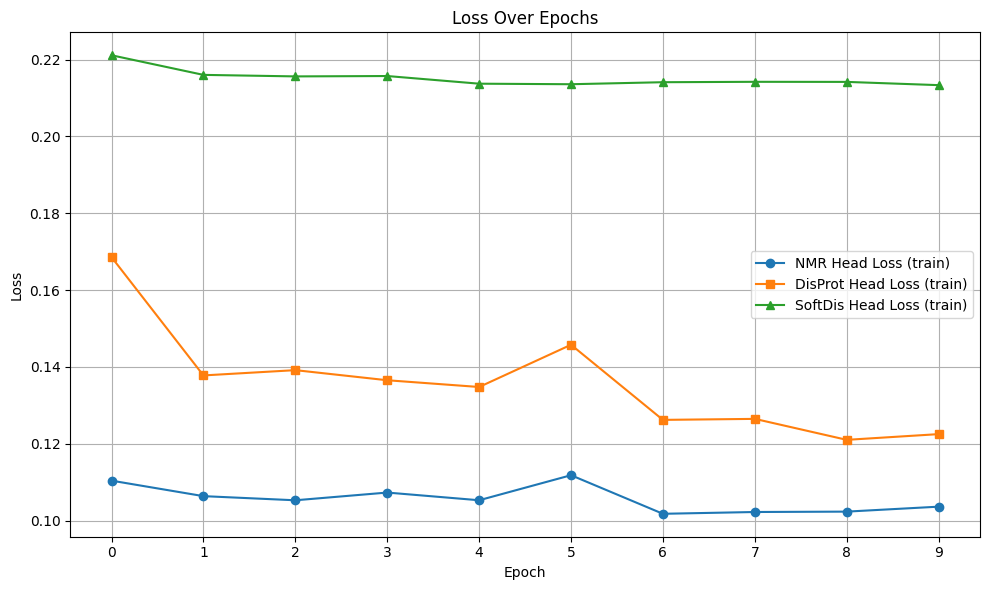

In [44]:
epochs = [i for i in range(len(disprot_loss_per_epoc))]

plt.figure(figsize=(10, 6))
plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss (train)', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss (train)', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss (train)', marker='^')

# plt.plot(epochs, val_nmr_losses_per_epoc, label='NMR Head Loss (val)', marker='.')
# plt.plot(epochs, val_disprot_losses_per_epoc, label='DisProt Head Loss (val)', marker='o')
# plt.plot(epochs, val_softdis_losses_per_epoc, label='SoftDis Head Loss (val)', marker='v')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_epochs_train.png")
plt.savefig(full_path)
plt.show()

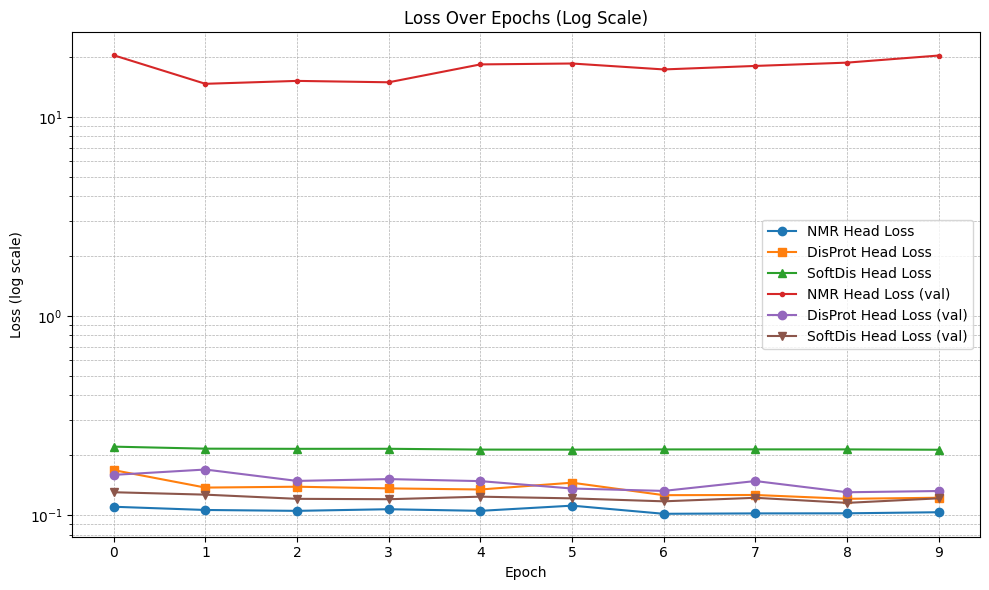

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss', marker='^')

plt.plot(epochs, val_nmr_losses_per_epoc, label='NMR Head Loss (val)', marker='.')
plt.plot(epochs, val_disprot_losses_per_epoc, label='DisProt Head Loss (val)', marker='o')
plt.plot(epochs, val_softdis_losses_per_epoc, label='SoftDis Head Loss (val)', marker='v')

plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Loss Over Epochs (Log Scale)")
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "log_loss_curve_per_epochs_all.png")
plt.savefig(full_path)
plt.show()


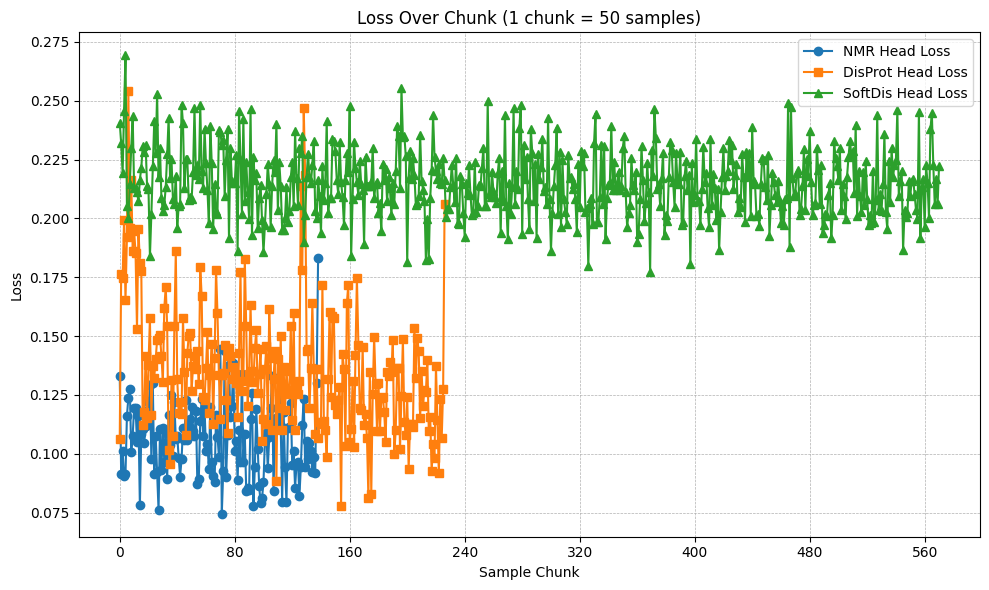

In [33]:
chunk_size = 50
nmr_loss_per_sample_smooth = [
    sum(nmr_loss_per_sample_total[i:i+chunk_size]) / len(nmr_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(nmr_loss_per_sample_total), chunk_size)
]
disprot_loss_per_sample_smooth = [
    sum(disprot_loss_per_sample_total[i:i+chunk_size]) / len(disprot_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(disprot_loss_per_sample_total), chunk_size)
]
softdis_loss_per_sample_smooth = [
    sum(softdis_loss_per_sample_total[i:i+chunk_size]) / len(softdis_loss_per_sample_total[i:i+chunk_size])
    for i in range(0, len(softdis_loss_per_sample_total), chunk_size)
]


epochs = list(range(len(disprot_loss_per_sample_smooth)))

plt.figure(figsize=(10, 6))

plt.plot(range(len(nmr_loss_per_sample_smooth)), nmr_loss_per_sample_smooth, label='NMR Head Loss', marker='o')
plt.plot(range(len(disprot_loss_per_sample_smooth)), disprot_loss_per_sample_smooth, label='DisProt Head Loss', marker='s')
plt.plot(range(len(softdis_loss_per_sample_smooth)), softdis_loss_per_sample_smooth, label='SoftDis Head Loss', marker='^')

plt.xlabel("Sample Chunk")
plt.ylabel("Loss")
plt.title(f"Loss Over Chunk (1 chunk = {chunk_size} samples)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_sample.png")
plt.savefig(full_path)
plt.show()


### Prediction on Test Data

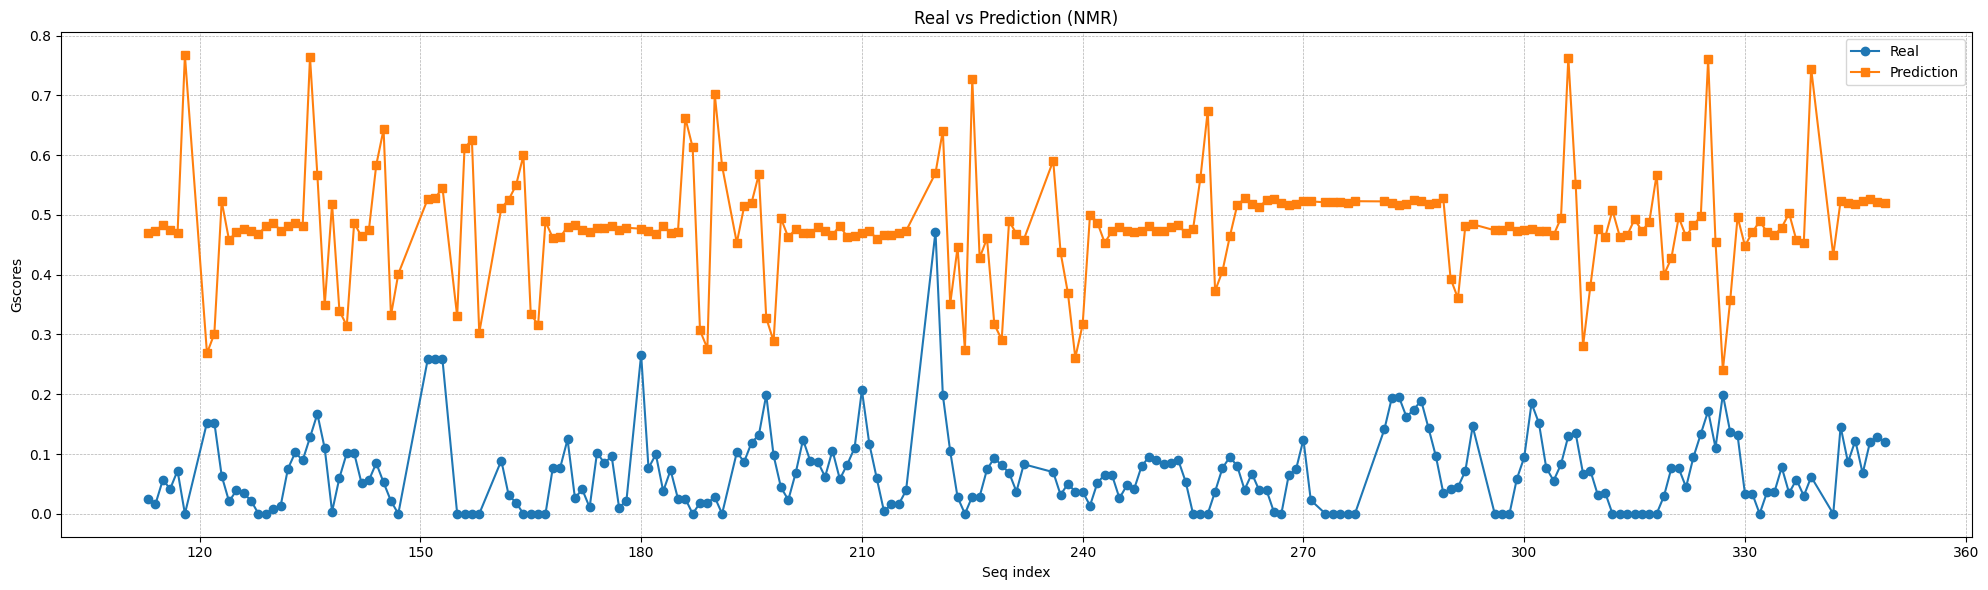

In [43]:
rand_idx = random.randint(1, 1000)
input_embeddings, input_plddt, target, mask, task_flag = test_data[rand_idx]
entropy.target_flag_ = task_flag

input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
mask_tf = tf.convert_to_tensor(mask[np.newaxis, ...], dtype=tf.bool)

data = (input_embeddings_tf, input_plddt_tf)
prediction = entropy.predict(data).numpy().reshape(-1)
# target = target.numpy().reshape(target.shape[1])

# mask filtering
mask_np = mask.astype(bool)
target_filtered = target[mask_np]
prediction_filtered = prediction[mask_np]
seq_idx = [i for i in range(len(mask)) if mask[i]]

if task_flag == "softdis_disorder":
    plt.figure(figsize=(20, 6))
    plt.plot(seq_idx, target_filtered, label='Real', marker='o')
    plt.plot(seq_idx, prediction_filtered, label='Prediction', marker='s')

    plt.xlabel("Seq index")
    plt.ylabel("Disorder")
    plt.title("Real vs Prediction (SoftDis)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    full_path = os.path.join(dir_path, "real_vs_prediction_softDis.png")
    plt.savefig(full_path)
    plt.show()

elif task_flag == "g_scores":
    plt.figure(figsize=(20, 6))
    plt.plot(seq_idx, target_filtered, label='Real', marker='o')
    plt.plot(seq_idx, prediction_filtered, label='Prediction', marker='s')

    plt.xlabel("Seq index")
    plt.ylabel("Gscores")
    plt.title("Real vs Prediction (NMR)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    full_path = os.path.join(dir_path, "real_vs_prediction_nmr.png")
    plt.savefig(full_path)
    plt.show()

else:
    print(f"Real: {target}, prediction: {prediction}, difference: {abs(prediction-target)}")

In [29]:
all_target = []
all_prediction = []

for input_embeddings, input_plddt, target, _, task_flag in test_data:
    if task_flag == "disprot_disorder":
        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)

        entropy.target_flag_ = task_flag
        data = (input_embeddings_tf, input_plddt_tf)
        prediction = entropy.predict(data).numpy().reshape(-1)
        target = target[0]
        # target = target.numpy().reshape(target.shape[1])

        all_target.append(target)
        all_prediction.append(prediction)

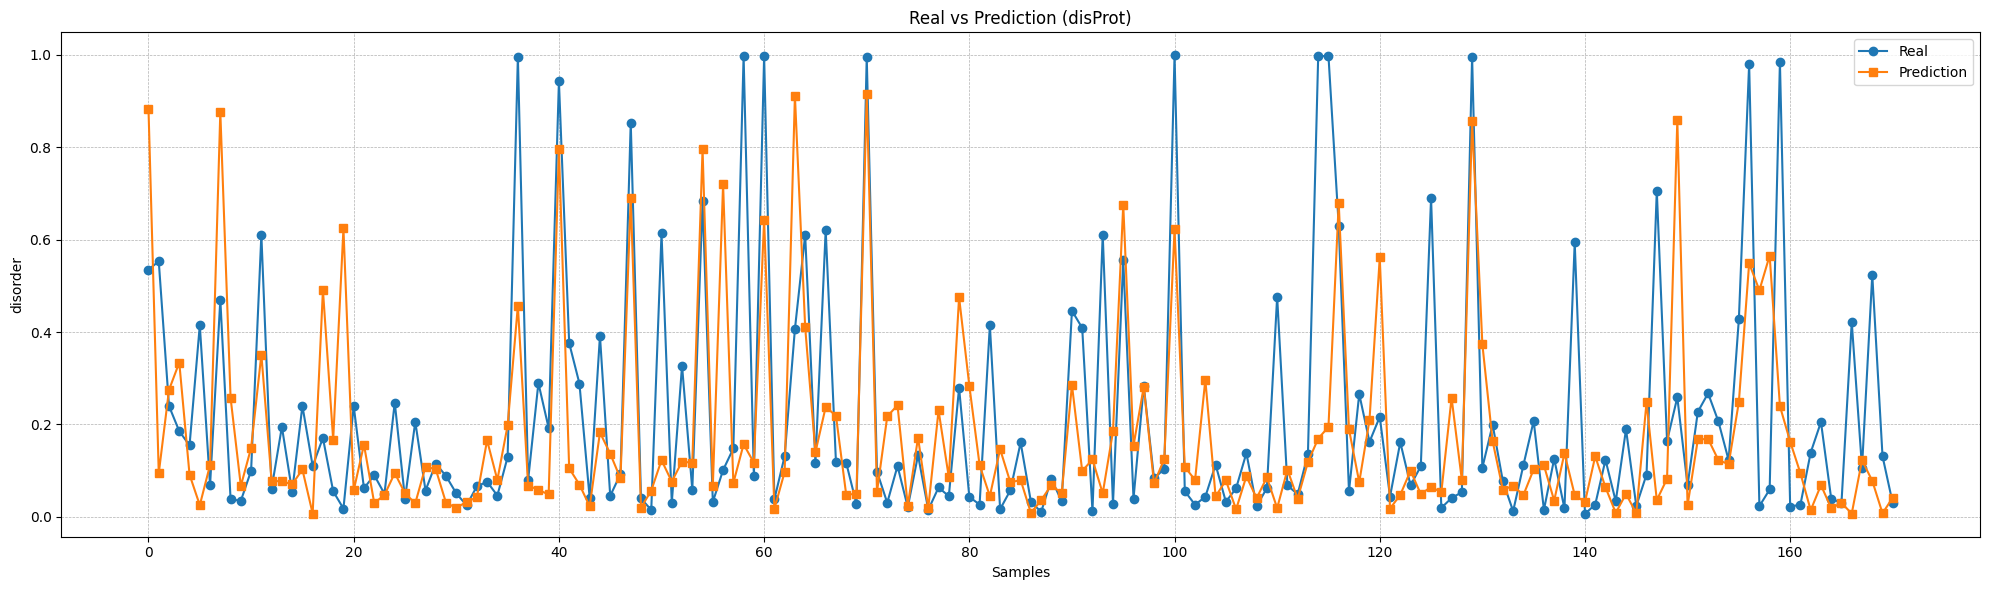

In [30]:
plt.figure(figsize=(20, 6))
seq_idx = [i for i in range(len(all_prediction))]
plt.plot(seq_idx, all_target, label='Real', marker='o')
plt.plot(seq_idx, all_prediction, label='Prediction', marker='s')

plt.xlabel("Samples")
plt.ylabel("disorder")
plt.title("Real vs Prediction (disProt)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "real_vs_prediction_disprot_train.png")
plt.savefig(full_path)
plt.show()